## 1 Data and package import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# pd.set_option('display.float_format', '{:.2f}'.format)

this dataset stems from: https://www.kaggle.com/code/bandiatindra/telecom-churn-prediction/input

In [3]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2 Data Inspection

### 2.1 Checking data types

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### 2.2 Transforming data

In [6]:
#Change values 0 and 1 to Yes and No in SeniorCitizen for consistent scaling
data['SeniorCitizen'] = data['SeniorCitizen'].map({1:'Yes',0:'No'})

#Change type of TotalCharges from object to numeric
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'],errors='coerce')

### 2.3 Checking levels in categorical variables

In [7]:
for col in data.columns[1:]:
    if data[col].dtype == 'object':
        print(f'{col} {data[col].unique()}')

gender ['Female' 'Male']
SeniorCitizen ['No' 'Yes']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


### 2.4 Checking missing values

In [8]:
#Check NA´s
data.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [9]:
#Inspect NA´s in dataframe
# data[data.TotalCharges.isna()]

In [10]:
#Insprect total charges when tenure=1
# data[data.tenure == 1]

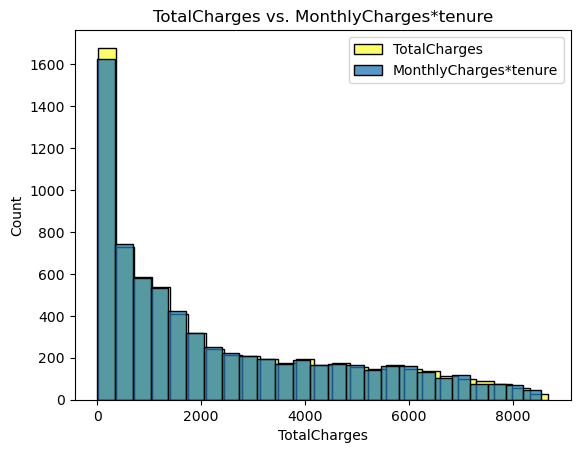

In [11]:
#Relationship total charges with monthlycharges * tenure
sns.histplot(data.TotalCharges, color='yellow',alpha=0.6,label='TotalCharges')
sns.histplot(data.MonthlyCharges*data.tenure,label='MonthlyCharges*tenure')
plt.title('TotalCharges vs. MonthlyCharges*tenure')
plt.legend()
plt.show()

In [12]:
#Replace monthly and total charges values with 0 where tenure = 0
data.loc[data['tenure'] == 0, 'MonthlyCharges'] = 0
data.loc[data['TotalCharges'].isna(), 'TotalCharges'] = 0

All Na´s in total charges have a monthly charges of 0. When you check the total charges with tenure == 1, total charges is the product of monthly charges times tenure. Its unclear why customers with tenure = 0 already have monthly charges when the total charges with tenure = 1 is the same as in monthly charges. Therefore Na´s and monthly charges in tenure = 0 will be replaced by 0.

### 2.5 Checking duplicates

In [13]:
data.duplicated().sum()

0

### 2.6 Delete reduntant variables

In [14]:
#Delete customerID - reduntant variable
data = data.drop('customerID',axis=1)

## 3 Churn Analysis

### 3.1 Churn Rate

 Customers who have a one year contract churn within their minimal contract duration. Its unclear why. Therefore it is assumend that these customers are outliers and will be deleted for data consistency.

In [15]:
# Proportion of customers with a one year contract, which churn within minimal contract duration
np.divide(data[(data.tenure <= 12) & (data.Churn == 'Yes') & (data.Contract == 'One year')]['Contract'].count(),
          data[(data.Churn == 'Yes') & (data.Contract == 'One year')]['Contract'].count()).round(2)

0.08

In [16]:
# Delete customers with a one year contract and churn within minimal contract duration
data = data[~((data.tenure <= 12) & (data.Churn == 'Yes') & (data.Contract == 'One year'))]

In [17]:
#Total Churn (1st Level)
(data[data.Churn == 'Yes']['Churn'].count() / len(data)).round(2)

0.26

In [18]:
# Churn Rate per Contract type (2nd Level)
(data[data.Churn == 'Yes']['Contract'].value_counts() / data.Contract.value_counts()).round(2)

Contract
Month-to-month    0.43
One year          0.10
Two year          0.03
Name: count, dtype: float64

### 3.2 Churn among tenure and Contract Types

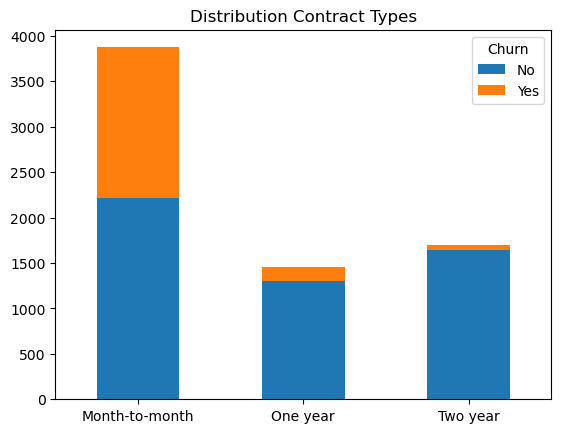

In [19]:
#Proportion contract types
data.groupby('Contract')['Churn'].value_counts().unstack().plot.bar(stacked=True)
plt.xticks(rotation=0)
plt.title('Distribution Contract Types')
plt.xlabel('')
plt.show()

In [20]:
data['Contract'].value_counts(normalize=True).round(2)

Contract
Month-to-month    0.55
Two year          0.24
One year          0.21
Name: proportion, dtype: float64

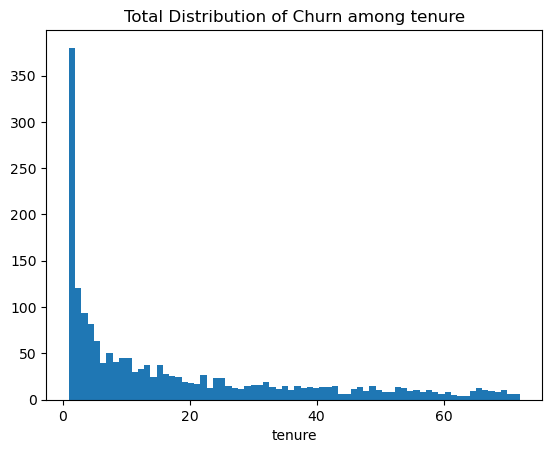

In [21]:
# Distribution churn among tenure
plt.hist(data=data[data.Churn == 'Yes'],x='tenure',bins=72)
plt.xticks(ticks=np.arange(min(data.tenure),max(data.tenure),3))
plt.title('Total Distribution of Churn among tenure')
plt.xlabel('tenure')
plt.xticks(ticks=np.arange(0,72,20))
# plt.grid(linestyle='--')
plt.show()

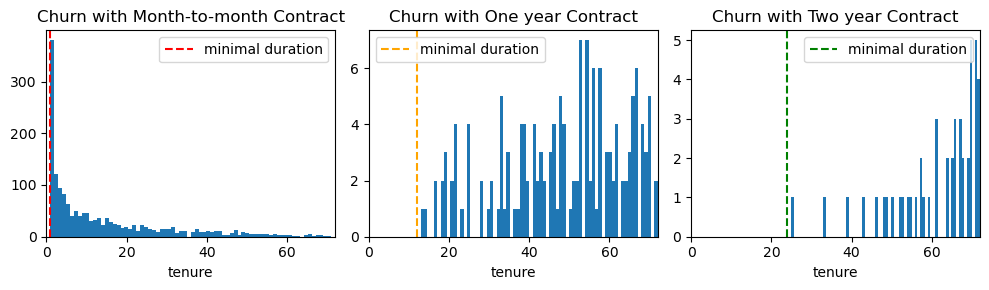

In [22]:
#Churn Distribution among Contract Types and
contract_types = ('Month-to-month','One year','Two year')

plt.figure(figsize=(10,3))
for i, contract_type in enumerate(contract_types):
    plt.subplot(1, 3, i + 1)
    plt.hist(data[(data.Churn == 'Yes') & (data.Contract == contract_type)]['tenure'], bins=72)
    plt.title(f'Churn with {contract_type} Contract')
    plt.xlabel('tenure')
    # plt.grid(linestyle='--')
    plt.xlim(0,72)

    if contract_type == 'Month-to-month':
        plt.axvline(1,color='red',linestyle='--',label='minimal duration')
    elif contract_type == 'One year':
        plt.axvline(12,color='orange',linestyle='--',label='minimal duration')
    else:
        plt.axvline(24,color='green',linestyle='--',label='minimal duration')
    plt.legend()
  
plt.tight_layout()
plt.show()

In [23]:
#Decription of contract types
for type in contract_types:
    print(f'{type}')
    print(data[(data.Contract == type) & (data.Churn == 'Yes')]['tenure'].describe().round())

Month-to-month
count    1655.0
mean       14.0
std        16.0
min         1.0
25%         2.0
50%         7.0
75%        21.0
max        71.0
Name: tenure, dtype: float64
One year
count    153.0
mean      48.0
std       16.0
min       13.0
25%       38.0
50%       51.0
75%       60.0
max       72.0
Name: tenure, dtype: float64
Two year
count    48.0
mean     61.0
std      11.0
min      25.0
25%      56.0
50%      66.0
75%      70.0
max      72.0
Name: tenure, dtype: float64


As shown in the description above, churns based on different time periods among the contract types. Customers who have a Month-to-month contract churn within a period of 70 months, customers who have a one year contract within 59 months and customers with a two year contract within 47 months.For this reason, churn among contract types must be defined per month to avoid a biased view.

In [24]:
# Churn Rate per contract type and month (3rd Level)
print('month_to_month_churn_per_month', np.round((1655 / (3875*70))*100,2))
print('one_year_churn_per_month', np.round((166 / (1495*70))*100,2))
print('two_year_churn_per_month', np.round((48 / (1695*47))*100,2))

month_to_month_churn_per_month 0.61
one_year_churn_per_month 0.16
two_year_churn_per_month 0.06


### 3.3 Churn among categorical variables

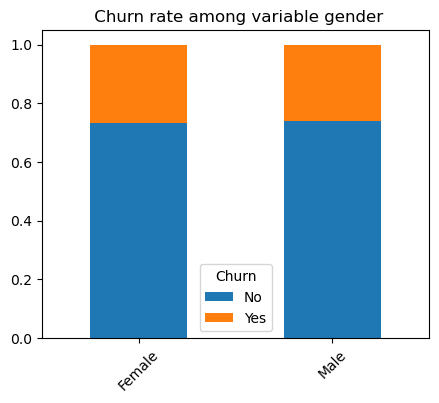

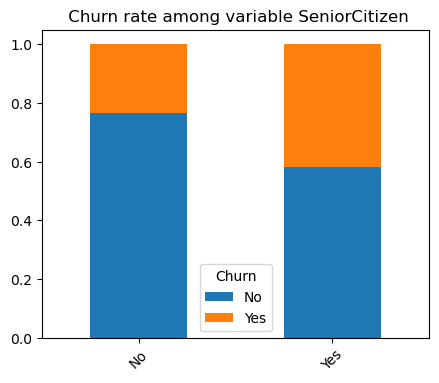

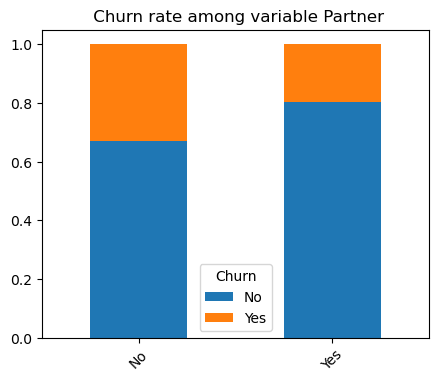

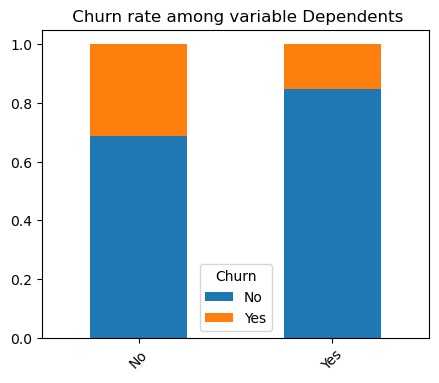

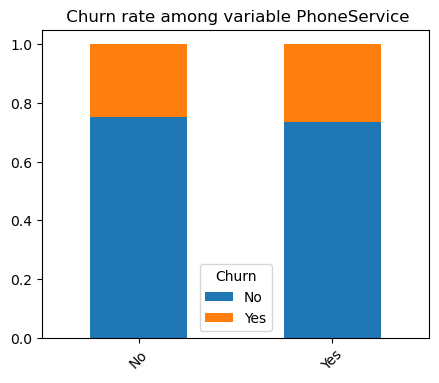

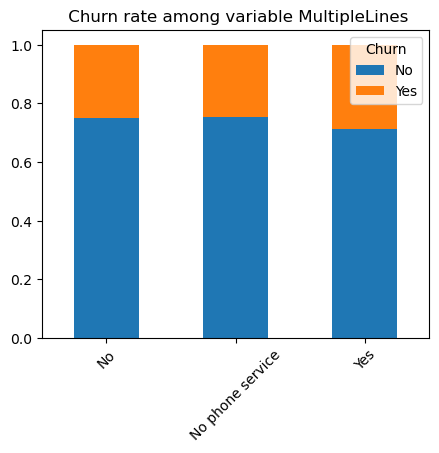

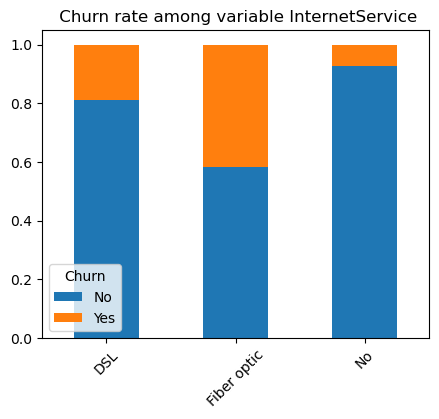

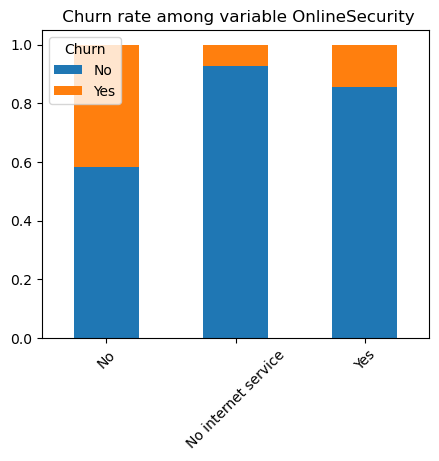

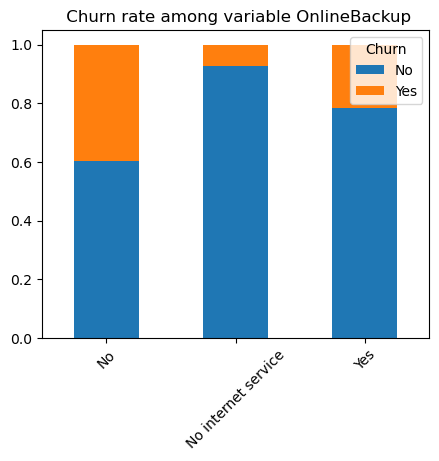

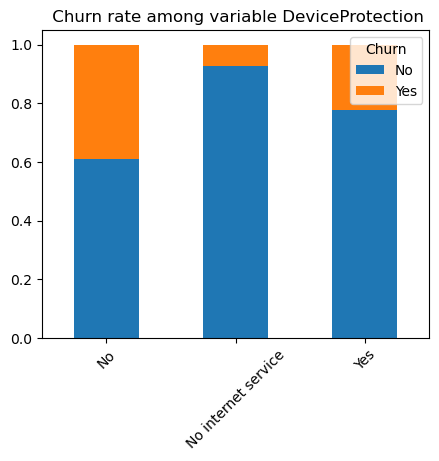

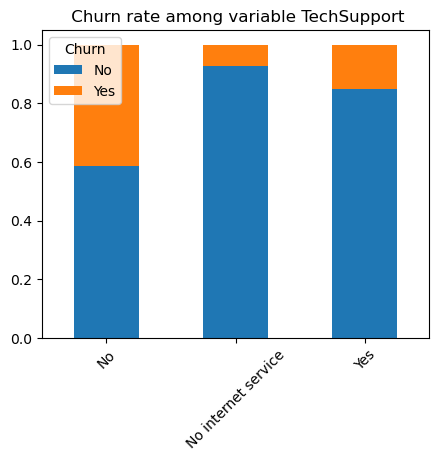

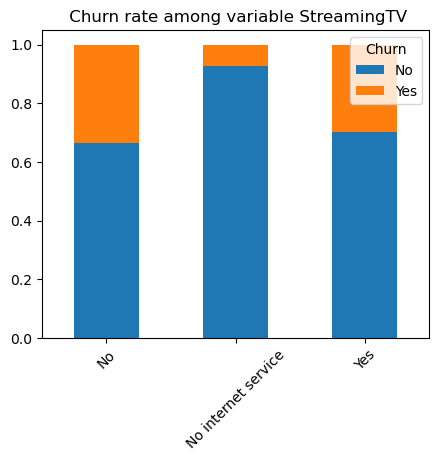

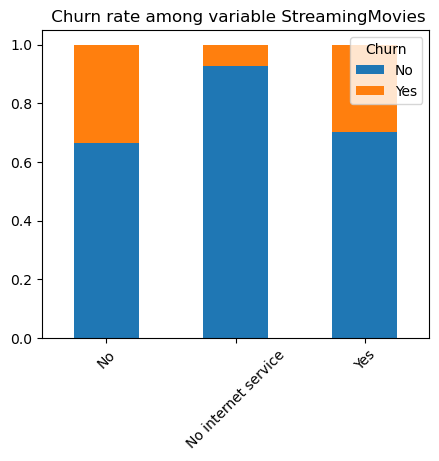

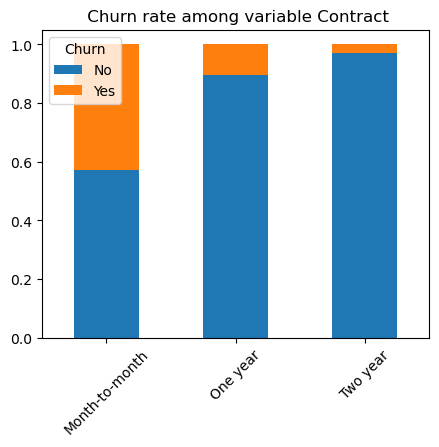

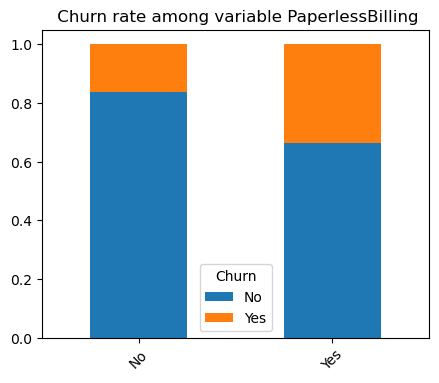

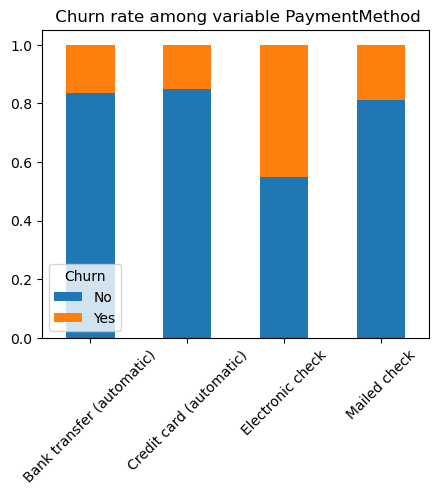

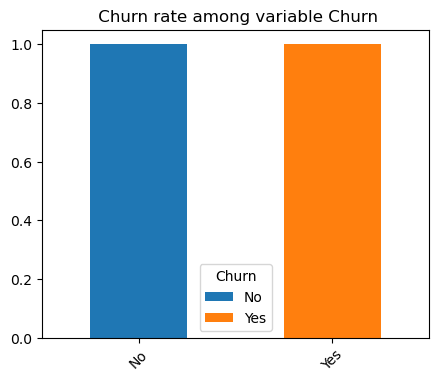

In [25]:
for var in data.columns:
    if data[var].dtype == 'object':
        churn_distribution = data.groupby([var,'Churn'])[var].value_counts() / data[var].value_counts()
        churn_distribution.unstack().plot.bar(stacked=True,figsize=(5,4))
        plt.title(f' Churn rate among variable {var}')
        plt.xticks(rotation=45)
        plt.xlabel('')
        plt.show()

In [26]:
#Pearson Correlation
data['tenure'].corr(data['TotalCharges'],method='pearson')

0.8259489196133213

## 4 Revenue Loss

In [68]:
data[['MonthlyCharges','TotalCharges']].describe()

,MonthlyCharges,TotalCharges
count,7030.000000,7030.000000
mean,64.723784,2283.138684
std,30.167479,2267.464283
min,0.000000,0.000000
25%,35.450000,399.700000
50%,70.350000,1397.950000
75%,89.850000,3795.212500
max,118.750000,8684.800000


### 3.7 Distribution Monthly and total charges among Churn

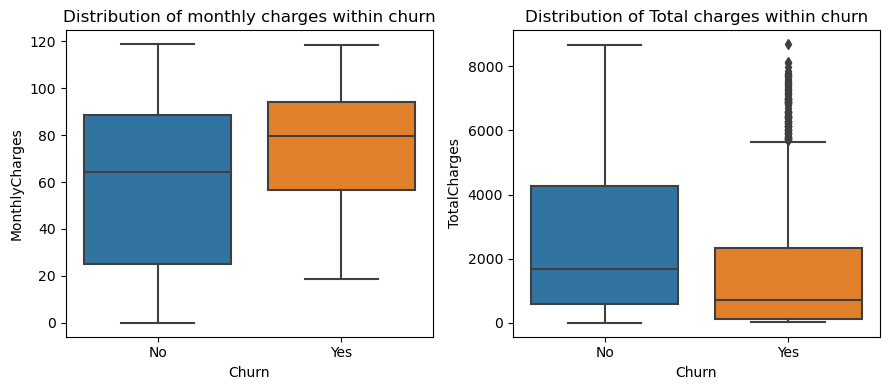

In [62]:
plt.figure(figsize=(9,4))

# Subplot 1
plt.subplot(1,2,1)
sns.boxplot(data=data,x='Churn',y='MonthlyCharges',width=0.8)
plt.title('Distribution of monthly charges within churn')

# Subplot 2
plt.subplot(1,2,2)
sns.boxplot(data=data,x='Churn',y='TotalCharges',width=0.8)
plt.title('Distribution of Total charges within churn')

plt.tight_layout()
plt.show()

In [29]:
#Describe MonthlyCharges among Churn
data.groupby('Churn')['MonthlyCharges'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
No,5174.0,61.18,31.19,0.00,25.05,64.40,88.40,118.75
Yes,1856.0,74.61,24.55,18.85,56.69,79.68,94.25,118.35


In [30]:
#Describe TotalCharges among Churn
data.groupby('Churn')['TotalCharges'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
No,5174.0,2549.91,2329.95,0.00,572.90,1679.52,4262.85,8672.45
Yes,1856.0,1539.45,1895.03,18.85,133.81,712.80,2345.88,8684.80


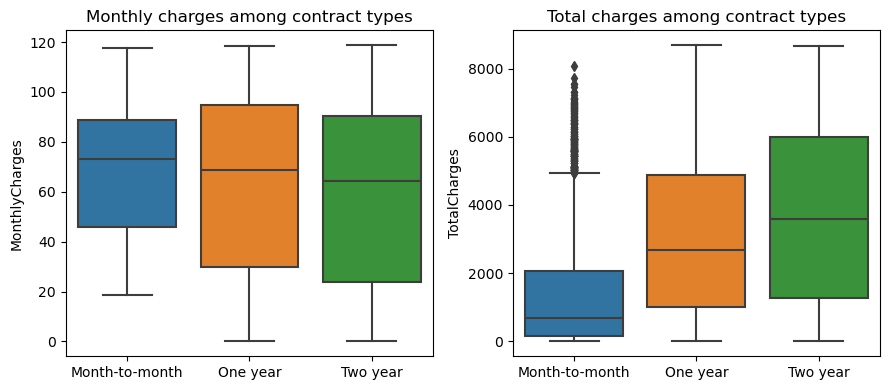

In [60]:
plt.figure(figsize=(9,4))

#Subplot 1
plt.subplot(1,2,1)
sns.boxplot(data=data,x='Contract',y='MonthlyCharges')
plt.title('Monthly charges among contract types')
plt.xlabel('')
plt.xticks(rotation=0)

#Subplot 2
plt.subplot(1,2,2)
sns.boxplot(data=data,x='Contract',y='TotalCharges')
plt.xlabel('')
plt.title('Total charges among contract types')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

### 3.8 Monthly and total charges among internet services 

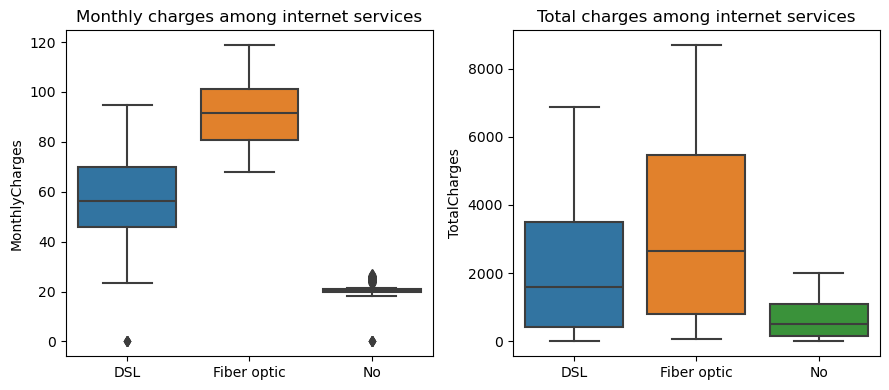

In [59]:
plt.figure(figsize=(9,4))

#Subplot 1
plt.subplot(1,2,1)
sns.boxplot(data=data,x='InternetService',y='MonthlyCharges')
plt.title('Monthly charges among internet services')
plt.xlabel('')
plt.xticks(rotation=0)

#Subplot 2
plt.subplot(1,2,2)
sns.boxplot(data=data,x='InternetService',y='TotalCharges')
plt.xlabel('')
plt.title('Total charges among internet services')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


In [32]:
#Description MonthlyCharges among InternetService
data.groupby('InternetService')['MonthlyCharges'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
InternetService,,,,,,,,
DSL,2414.0,57.98,16.46,0.00,46.00,56.15,69.85,94.80
Fiber optic,3094.0,91.49,12.66,67.75,80.55,91.65,101.15,118.75
No,1522.0,21.00,2.53,0.00,19.70,20.15,20.90,26.90


In [33]:
#Description TotalCharges among InternetService
data.groupby('InternetService')['TotalCharges'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
InternetService,,,,,,,,
DSL,2414.0,2120.01,1881.44,0.0,431.31,1607.75,3495.11,6859.05
Fiber optic,3094.0,3206.87,2570.30,68.5,796.05,2662.70,5452.72,8684.80
No,1522.0,664.06,555.62,0.0,159.01,521.17,1109.74,2006.95


### 3.9 Summary

* There a 3 levels of Churn: The first level is definied as the total churn within 6 years. The second level is definied as churn per contract type. And the third level is definied as churn per contract type and tenure:

- `1st Level (Total Churn): 26%` 
 
- ` 2nd Level (Churn per contract type):`
    * Month-to-month: 43%
    * One year: 10% 
    * Two year: 3%  
- `3rd Level (Churn per contract type per month:`
    * Month-to-month: 0.61% 
    * One year: 0.16%
    * Two year: 0.06%` 

* 55% of the customers decide for a month-to-month contract, followed by 24% customers which decide for a two year contract. 21% have a one year contract.
* A substantial part of customers who have a month-to-month contract churn already after a few months after the start of the contract. Specially a high percentage of customers churn in the first month. The distribution is right skewed. The distribution of two years contracts is the opposite. More customers only churn after 35 months after beginning of their contract. Unclear ist the distribution with one year contracts. Even though its possible to churn at least after 24 months, however, they are customers who churn under their minimal contract duration.

In [34]:
data.to_csv('data_ml.csv')